In [34]:
'''
Download Data Set here 
Roadmap:

import arcgis

MVP     - Image classifier for B
MVP+1   - Image Classifier for A, B, C, Five, Point
MVP_ASL - Image Classifier for A, B, C, D, E... Z
Proto   - Image Classifier for Dictionary words
Proto + second hand
Proto + body
Product - Video image Classifer <> GoPro, Kinect
Final   - Works in an 'Google Translator' App
'''

"\nDownload Data Set here \nRoadmap:\n\nimport arcgis\n\nMVP     - Image classifier for B\nMVP+1   - Image Classifier for A, B, C, Five, Point\nMVP_ASL - Image Classifier for A, B, C, D, E... Z\nProto   - Image Classifier for Dictionary words\nProto + second hand\nProto + body\nProduct - Video image Classifer <> GoPro, Kinect\nFinal   - Works in an 'Google Translator' App\n"

In [35]:
import os, glob, cv2, random, re, keras, tensorflow, itertools
import numpy as np
import pandas as pd
import skimage.io as skio
import skimage.transform as skt
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from IPython.core.interactiveshell import InteractiveShell
from sklearn.cross_validation import train_test_split, cross_val_score

%matplotlib inline

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [37]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, consensus_score, roc_auc_score, roc_curve, auc

In [49]:
'''
collecting all data locations into lists
<> replace with code to check ./input for images, add to data
'''

part_five  = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/Five/*')]
part_a     = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/A/*')]
part_b     = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/B/*')]
part_point = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/Point/*')]
part_c     = [image for image in glob.glob('../Daka/ALS_translator/Marcel-Train/C/*')]

('p5', len(part_five)), ('pa', len(part_a)), ('pb', len(part_b)), ('pp', len(part_point)), ('pc',len(part_c))

(('p5', 654), ('pa', 1329), ('pb', 487), ('pp', 1395), ('pc', 572))

In [50]:
'''
concating data locations into one list
'''

full = [part_a, part_b, part_c, part_point, part_five]
image_paths= []
for dataset in full:
    image_paths.extend(dataset)
    
'''sanity check'''
image_paths[1], image_paths[2001]

('../Daka/ALS_translator/Marcel-Train/A/A-train0910.ppm',
 '../Daka/ALS_translator/Marcel-Train/C/C-train521.ppm')

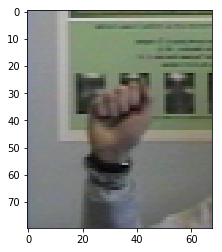

In [51]:
old = plt.imread(image_paths[1])
plt.imshow(old)

/Users/njume/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/njume/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


((64, 64), (64, 64, 1))

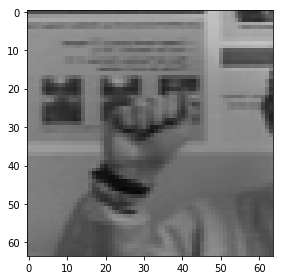

In [52]:
'''length X width X channel (64,64, 1) does not work with skimage, it breaks plt'''
first_pic_sk = skio.imread(image_paths[0], as_grey=True)
first_pic_skt = skt.resize(first_pic_sk,(64,64,1))
# skio.imshow(first_pic_skt)

first_pic_sk2 = skt.resize(first_pic_sk,(64, 64))
skio.imshow(first_pic_sk2)
first_pic_sk2.shape, first_pic_skt.shape

In [53]:
'''
working image size will be 64x64
'''

all_images = []
largest = 0,0
for image in image_paths:
    img = skio.imread(image, as_grey=True)
    img = img.astype('float32')
    img = skt.resize(img,(64, 64))
    all_images.append(img)
    
    '''sanity check'''
    if img.shape > largest:
        largest = img.shape
        print(image)
        print(largest)
        
converted_X = np.array(all_images)

/Users/njume/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


../Daka/ALS_translator/Marcel-Train/A/A-train0904.ppm
(64, 64)


In [54]:
'''COMPARISON PURPOSES. REMEMBER IT READS IMAGES AS BGR NOT RGB,
the quality of the photo is the same when reshaped'''
# cv_image = cv2.imread(image_paths[0], 0)
# cv_image = cv2.resize(cv_image, (32,32))
# plt.imshow(cv_image)

'COMPARISON PURPOSES. REMEMBER IT READS IMAGES AS BGR NOT RGB,\nthe quality of the photo is the same when reshaped'

In [55]:
 '''Setting y target'''
target     = []

for path in image_paths:
    if re.search((r'\/input\/Marcel-Train\/B'), path) != None:
        target.append(1)
    else:
        target.append(0)

'''cant figure out list coprehension or lambda for this'''
# [c if re.search((r'\/input\/Marcel-Train\/B') == None, path) for path in image_paths]        
# <>forloop<>target.append(lambda x: 0 if path != None else 1)

'''Sanity Check'''
_ = pd.DataFrame(target)
_[0].value_counts()

0    4437
Name: 0, dtype: int64

In [56]:
'''Setting X, y'''
y = target
X = converted_X

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)
X_train[0]    # this is one image
X_train[0][0] # this is one row of that image

array([0.63, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.74, 0.82,
       0.82, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81,
       0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82,
       0.82, 0.82, 0.82, 0.82, 0.81, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82,
       0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.83,
       0.83, 0.83, 0.82, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83])

(64, 64)

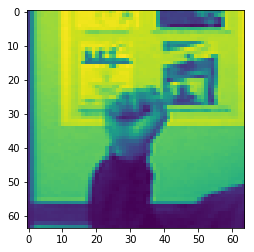

In [57]:
'''sanity check'''
plt.imshow(X_train[5])
X_train[5].shape

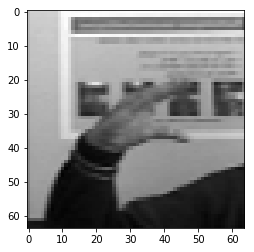

In [58]:
'''why isn"t this what is shown'''
plt.imshow(X_train[0],cmap=plt.get_cmap('gray'))

In [59]:
'''from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        fill_mode='nearest')

# img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
X_train.reshape((1,)+ X_train.shape)
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(X_train, batch_size=1,save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely
def image_gen(batch_size, y_dict, path):
    directory = os.listdir(path=path)
    Xout = []
    yout = []
    counter = 0
    for filename in it.cycle(directory):
        if '.jpg' in filename:
            try:
                yout.append(y_dict[filename])
                img=cv2.imread(path + filename)
                img = img/255
                img.reshape(1,400,640,3)
                Xout.append(img)
                counter += 1
                if counter % batch_size == 0:
                    yield (np.array(Xout), np.array(yout))#np.random.randint(2, size=batch_size))
                    Xout = []
                    yout= []
            except:
                continue'''
print('')

In [60]:
'''
onehotvector
softmax
categorical cross entropy
mvp binary cross entropy
'''
X_train.max(), X_test.min()

(0.9960784316062927, 0.0)

In [61]:
X_train.shape

(3105, 64, 64)

In [67]:
'''nn imported from lesson'''
model = Sequential()
model.add(Conv2D(filters = 6, 
                 kernel_size= 3, 
                 activation='relu', 
                 input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 16,
                 kernel_size= 3,
                 activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [68]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [69]:
X_train = X_train.reshape(X_train.shape[0],64,64,1)
X_test = X_test.reshape(X_test.shape[0],64,64,1)

In [ ]:
model.fit(X_train, y_train,
          batch_size=6, epochs=30)

Epoch 1/30
3105/3105 [==============================] - 5s 2ms/step - loss: 0.0025 - acc: 0.9997
Epoch 2/30
3105/3105 [==============================] - 5s 2ms/step - loss: 1.0699e-07 - acc: 1.0000
Epoch 3/30
3105/3105 [==============================] - 5s 2ms/step - loss: 1.0792e-07 - acc: 1.0000
Epoch 4/30
3105/3105 [==============================] - 5s 2ms/step - loss: 1.0402e-07 - acc: 1.0000
Epoch 5/30
3105/3105 [==============================] - 5s 2ms/step - loss: 1.0728e-07 - acc: 1.0000
Epoch 6/30
3105/3105 [==============================] - 5s 2ms/step - loss: 1.0850e-07 - acc: 1.0000
Epoch 7/30
3105/3105 [==============================] - 5s 2ms/step - loss: 1.1778e-07 - acc: 1.0000
Epoch 8/30
3105/3105 [==============================] - 5s 2ms/step - loss: 1.0211e-07 - acc: 1.0000
Epoch 9/30
3105/3105 [==============================] - 5s 2ms/step - loss: 1.0188e-07 - acc: 1.0000
Epoch 10/30
2430/3105 [======================>.......] - ETA: 1s - loss: 1.1262e-07 - acc: 1.00

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
labels = model.metrics_names
print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

loss: 1.0002290729538821e-07
acc: 1.0


In [22]:
y_pred = model.predict(X_test)

In [23]:
y_pred.max(), y_pred.min()

(1.2128076e-07, 6.1817528e-15)

In [24]:
np.round([p for p in y_pred]).tolist()

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],


In [25]:
'''http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py'''
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
def Confusion_m(cnf_matrix):
    
    # cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Not B', 'is B'],
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Not B', 'is B'], normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

Confusion matrix, without normalization
[[1332]]
Normalized confusion matrix
[[1.]]


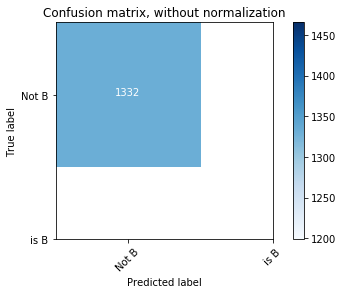

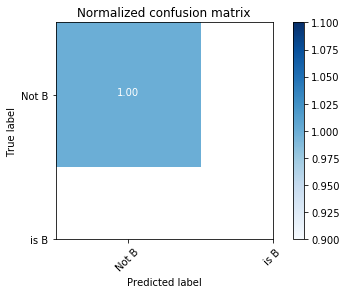

In [27]:
cnf_matrix = confusion_matrix(y_test,np.round(y_pred))
Confusion_m(cnf_matrix)

In [28]:
'''bargraph full'''
# ('p5', len(part_five)), ('pa', len(part_a)), ('pb', len(part_b)), ('pp', len(part_point)), ('pc',len(part_c))
# plt.bar(full)

'bargraph full'

In [29]:
print(sum(y_test), "All B's in test set"),print(len(y_test), 'All images in test set')

0 All B's in test set
1332 All images in test set


(None, None)

In [30]:
'''http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py'''

def plot_roc(y_test, probs):
    '''save this for references'''
#     probas = model.predict_proba(X_test)
#     probs = probas[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC'),
    plt.plot(fpr, tpr,
             color = 'b',
             label = 'AUC = {0}'.format(roc_auc))
    
    plt.legend(loc = 'lower right')
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

/Users/njume/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


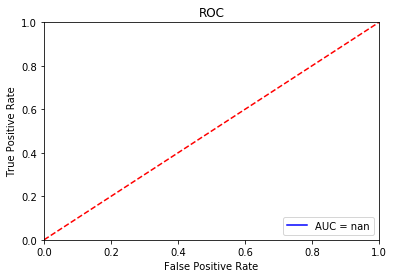

In [31]:
plot_roc(y_test, np.round(y_pred))

In [48]:
baseline = _[0].mean()
baseline

0.0